# Dogs V.S. Cats
## Environment Configuration

In [1]:
%pip install kaggle


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
!kaggle competitions download -c dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip -q -n dogs-vs-cats.zip


In [4]:
!unzip -q -n train.zip

## Build Custom Dataset

In [1]:
import os, shutil, pathlib

In [2]:
original_dir = pathlib.Path('train')
new_base_dir = pathlib.Path('cats_vs_dogs_small')

def make_subset(subset_name, start_index, end_index):
    for category in ('cat', 'dog'):
        dir = new_base_dir / subset_name / category
        try:
            os.makedirs(dir)
        except FileExistsError:
            return
        fnames = [f"{category}.{i}.jpg"
                  for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset('train', 0, 1000)
make_subset('validation', 1000, 1500)
make_subset('test', 1500, 2500)

## Building the model

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [8]:
inputs= keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory

In [5]:
train_dataset = image_dataset_from_directory(
    directory=new_base_dir / 'train',
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    directory=new_base_dir / 'validation',
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    directory=new_base_dir / 'test',
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [12]:
for data_batch, labels_batch in train_dataset:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='convnet_from_scratch.keras',
        save_best_only=True,
        monitor='val_loss')
]

In [14]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 338ms/step - accuracy: 0.5031 - loss: 0.7155 - val_accuracy: 0.5000 - val_loss: 0.6920
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 338ms/step - accuracy: 0.5081 - loss: 0.6960 - val_accuracy: 0.5620 - val_loss: 0.6825
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 359ms/step - accuracy: 0.5885 - loss: 0.6844 - val_accuracy: 0.5600 - val_loss: 0.6894
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 347ms/step - accuracy: 0.6103 - loss: 0.6603 - val_accuracy: 0.6340 - val_loss: 0.6487
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 365ms/step - accuracy: 0.6230 - loss: 0.6504 - val_accuracy: 0.6400 - val_loss: 0.6273
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 338ms/step - accuracy: 0.6718 - loss: 0.6257 - val_accuracy: 0.6160 - val_loss: 0.6399
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 357ms/step - accuracy: 0.6687 - loss: 0.5960 - val_accuracy: 0.6000 - val_loss: 0.8976
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 348ms/step - accuracy: 0.7181 - loss: 0.5558 - val_accu

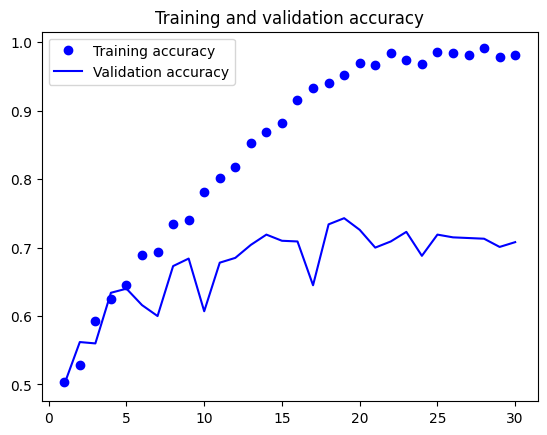

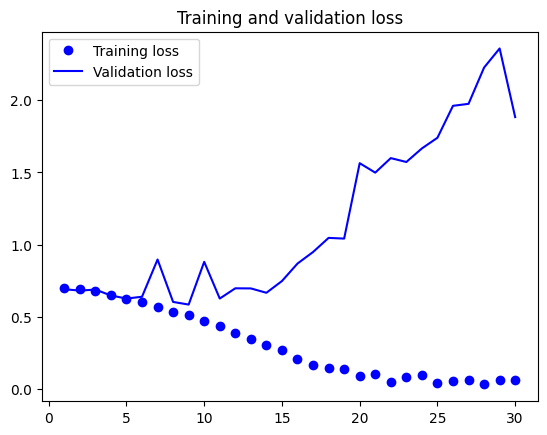

In [15]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [16]:
test_model = keras.models.load_model('convnet_from_scratch.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.2f}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.6695 - loss: 0.6128
Test accuracy: 0.67


### Using Data Augmenmtation

In [17]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

2024-09-19 11:59:55.938753: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


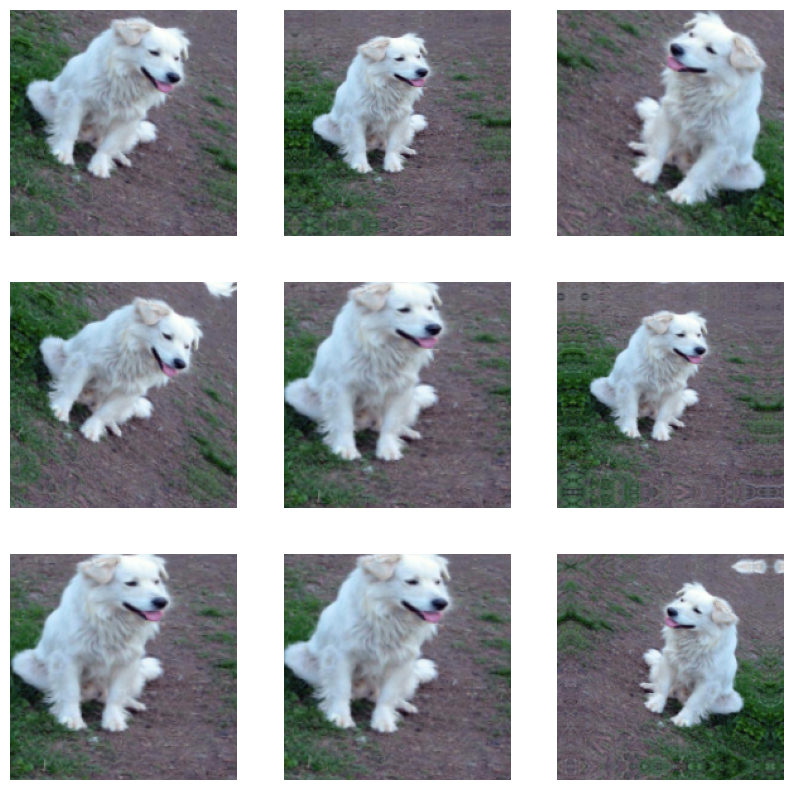

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8")) 
        plt.axis("off")

In [19]:
inputs= keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [20]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [21]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='convnet_from_scratch_with_augmentation.keras',
        save_best_only=True,
        monitor='val_loss')
]

In [22]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 346ms/step - accuracy: 0.4981 - loss: 0.7459 - val_accuracy: 0.5620 - val_loss: 0.6927
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 347ms/step - accuracy: 0.4996 - loss: 0.6939 - val_accuracy: 0.5000 - val_loss: 0.6920
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 351ms/step - accuracy: 0.5024 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6868
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 356ms/step - accuracy: 0.5608 - loss: 0.6967 - val_accuracy: 0.5000 - val_loss: 0.7780
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 347ms/step - accuracy: 0.5634 - loss: 0.6927 - val_accuracy: 0.6410 - val_loss: 0.6446
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 340ms/step - accuracy: 0.6261 - loss: 0.6562 - val_accuracy: 0.6400 - val_loss: 0.6277
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 340ms/step - accuracy: 0.6433 - loss: 0.6326 - val_accuracy: 0.6430 - val_loss: 0.6393
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 339ms/step - accuracy: 0.6728 - loss: 0.6356 - 

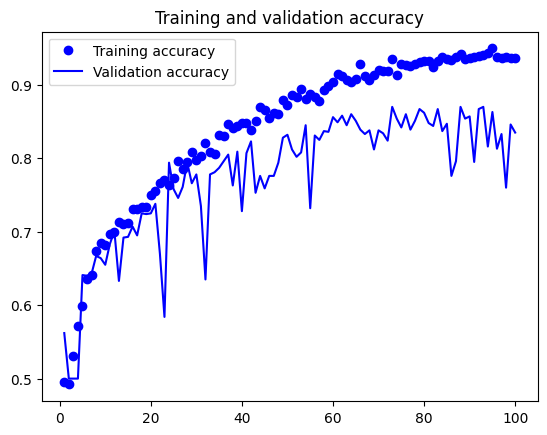

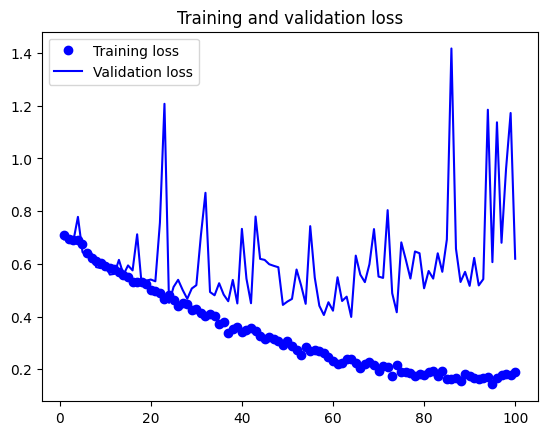

In [23]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [24]:
test_model = keras.models.load_model('convnet_from_scratch_with_augmentation.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.2f}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.8556 - loss: 0.5051
Test accuracy: 0.85


# Leveraging Pretrained Model


In [6]:
conv_base = keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))

In [7]:
import numpy as np

def get_feature_and_labels(datasets):
    all_features = []
    all_labels = []
    for images, labels in datasets:
        preprocess_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocess_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

In [8]:
train_features, train_labels = get_feature_and_labels(train_dataset)
val_features, val_labels = get_feature_and_labels(validation_dataset)
test_features, test_labels = get_feature_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

2024-09-21 22:50:05.206307: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

2024-09-21 22:50:45.278390: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [9]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [10]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='feature_extraction.keras',
        save_best_only=True,
        monitor='val_loss'
    )
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8790 - loss: 37.4307 - val_accuracy: 0.9310 - val_loss: 11.3880
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9734 - loss: 2.9902 - val_accuracy: 0.9590 - val_loss: 6.8677
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 2.6981 - val_accuracy: 0.9660 - val_loss: 5.9291
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9812 - loss: 2.3470 - val_accuracy: 0.9680 - val_loss: 5.0149
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9966 - loss: 0.3012 - val_accuracy: 0.9780 - val_loss: 3.3876
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9942 - loss: 0.4230 - val_accuracy: 0.9730 - val_loss: 5.0014
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9964 - loss: 0.4223 - val_accuracy: 0.9720 - val_loss: 4.5877
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9965 - loss: 0.2648 - val_accuracy: 0.9710 - val_los

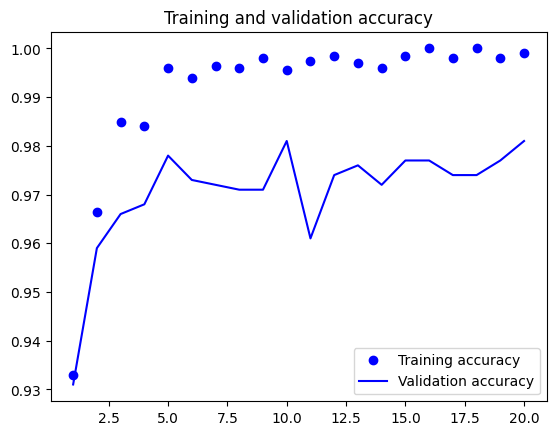

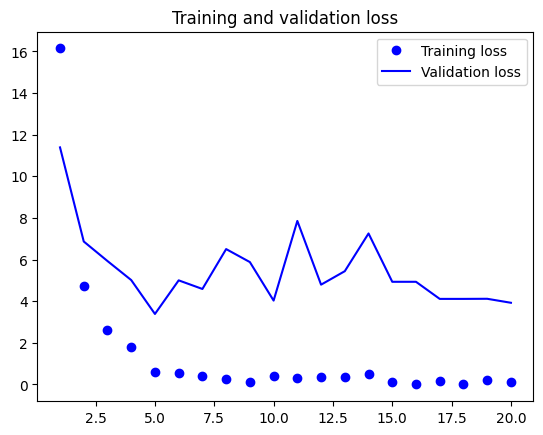

In [12]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Feature Extraction

In [18]:
conv_base = keras.applications.VGG16(
    weights='imagenet',
    include_top=False)
conv_base.trainable = False
print('This is the number of trainable weights '
        'after freezing the conv base:', len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [24]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [25]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [26]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss",
    )
]

In [28]:

with tf.device("/MPS:0"):
    # Your Keras model definition and training code here
    history = model.fit(
        train_dataset,
        epochs=50,
        validation_data=validation_dataset,
        callbacks=callbacks
    )

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.8147 - loss: 44.2933 - val_accuracy: 0.9700 - val_loss: 3.7816
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.9490 - loss: 5.8323 - val_accuracy: 0.9740 - val_loss: 3.7300
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9608 - loss: 6.9386 - val_accuracy: 0.9620 - val_loss: 6.3664
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.9476 - loss: 6.1072 - val_accuracy: 0.9760 - val_loss: 4.2338
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.9631 - loss: 3.7360 - val_accuracy: 0.9750 - val_loss: 3.7930
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.9683 - loss: 2.5538 - val_accuracy: 0.9730 - val_loss: 5.8398
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.9652 - loss: 3.4143 - val_accuracy: 0.9790 - val_loss: 3.2639
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.9674 - loss: 4.2483 - val_accuracy: 0.9770 - 

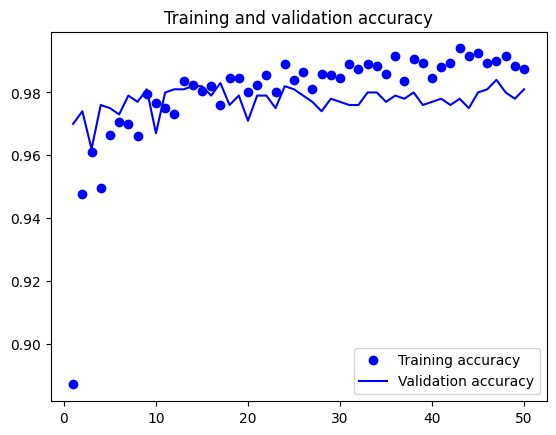

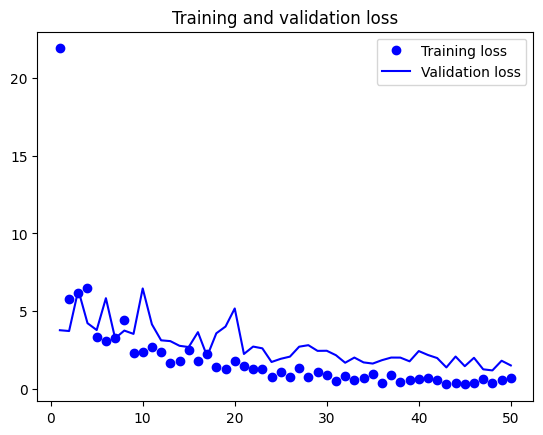

In [29]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()